# Subject Data PreProcessing
* find subject data
* concatenate the inter-session data
* concatenate the intra-session data

## Configuration

In [1]:
# General configuration
import os

# data_directory: str
#     Path to a directory to store data.
data_directory = '.'

# install_missing_packages: bool
#     A flag indicating if missing packages should be automatically installed
install_missing_packages = True

# use_conda: bool
#     A flag indicating if conda should be used for software installation.
#     If False, pip will be used. The default is to use conda if jupyter
#     is run in a conda environment.
use_conda = 'CONDA_EXE' in os.environ

## Checking for missing packages

In [2]:
import importlib

def check_package(package, pip_pkg: str = None, conda_pkg: str = None):
    """Check if a given package is installed. If missing install
    it (if global flag `install_missing_packages` is True) either with
    pip or with conda (depending on `use_conda`).
    """
    if importlib.util.find_spec(package) is not None:
        return  # ok, package is already installed

    if not install_missing_packages:
        raise RuntimeError(f"{package} is not installed!")

    if use_conda:
        import conda.cli
        conda.cli.main('conda', 'install',  '-y', conda_pkg or package)
    else:
        import subprocess
        import sys            
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_pkg or package])
        
# This is to exit cells without error tracebacks (cosmetic purpose)
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [4]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

Overwriting graphs.yml


### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

## Main Part

### Imports and directory information

In [4]:
import os
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nX
import glob
import scipy.cluster.vq as clusters
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 


OG_DATA_PATH = './'
DATA_PATH = './Data Exploration/'

# Reset the Datapath since the data is not yet on Git, comment out if data is on Git 
DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Data Exploration/'

PROCESSED_DATA_PATH = './Results/'
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)

### Extracting all subject IDs from the data folder

In [5]:
subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)
print(subIDs)

[1013 1019 1023 1079 1080 7357]


In [24]:
# custom subID
subIDs = [1023]

### Combine the data
* Loop through all subjects
* extract the session data
* combine the data
* save it

In [147]:
# Preparation
# column name list for dataframe
col_names =  ['Session',
              'timeStampDataPointStart',
              'timeStampDataPointEnd',
              'hitObjectColliderName', 
              'ordinalOfHit', 
              'hitPointOnObject.x',
              'hitPointOnObject.y',
              'hitPointOnObject.z',
              'hitObjectColliderBoundsCenter.x',
              'hitObjectColliderBoundsCenter.y',
              'hitObjectColliderBoundsCenter.z']

subcount = 0

# --------- first layer - subject loop ---------
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # Create empty dataframe for later concatenation
    complete_exploration_df = pd.DataFrame(columns = col_names)
    
    # get the data files according to the subject, ignoring OnQuit files
    subject_folder = sorted([f for f in DATA_FOLDER 
                             if f.startswith(str(subject)+'_Expl_S_') and f.endswith("OnQuit.json") == False], 
                            key=str.lower) 
    # the following works as long as the data name format is as follows:
    # 'subjectID'_Expl_S_'SessionNumber'_ET_'EyeTrackingSessionNumber'_'UnixTimestamp'.json
    folder_files = list()
       
    # loop through the subject folder and save all numbers
    for file in subject_folder:
        folder_files.append(re.findall(r'\d+', file))
    
    # Extract all SubIDs (only one), SessionNumbers, ET_SessionNumbers (and Timestamps)
    SubID, SessionNumbers, ET_SessionNumbers, UnixTimestamp1, UnixTimeStamp2 = map(list, zip(*folder_files))
    
    session_number = int(max(SessionNumbers)) # the maximum session number of the particular subject
    
    
# --------- second layer - exploration session loop ---------
    # loop over exploration sessions
    for EXP_session in range(session_number):
        # to avoid start at 0
        EXP_session +=1 

        # extract the exploration data
        subject_data = sorted([f for f in DATA_FOLDER if f.startswith(str(subject)+'_Expl_S_'+ str(EXP_session)) 
                               and f.endswith("OnQuit.json") == False], key=str.lower)

        
        # hitpoint dataframe 
        complete_hitpoints_df = pd.DataFrame(columns = col_names)

        print("\tTotal Sessionfiles: " + str(len(subject_data)) + " - Exploration Session " + str(EXP_session))
        s = 0 # session count
        
# --------- third layer - eye tracking session loop ---------
        # loop over separate eye tracking sessions
        for ET_session in subject_data:
            s+=1
            print("\tSession " + str(s) + " started")

            # open the JSON file as dictionary
            with open(DATA_PATH + ET_session) as f:
                try:
                    subject_session = json.loads(f.read())
                except:
                    print("\tJSON file " + ET_session + " is not valid!")

            hitpoint_list = list() # create hitpoint list

            # amount of datapoints 
            Len_subses = len(subject_session['trials'][0]['dataPoints'])


            # for loop appending each data point rayCastHit Data
            # afterwards adding the timestamp to the dict 
            # passing if there is (1) no raycast hit and (2) if there is only one raycast hit
            for idx in range(Len_subses):
                each = subject_session['trials'][0]['dataPoints'][idx]
                #print(len(each['rayCastHitsCombinedEyes']))
                
                # Error: When appending an empty dict the index gets out of bound! Needs solving
                

                hitpoint_list.append(each['rayCastHitsCombinedEyes'])

                #hitpoint_list[idx][0]['Session'] = EXP_session
                hitpoint_list[idx][0]['timeStampDataPointStart'] = each['timeStampDataPointStart']
                hitpoint_list[idx][0]['timeStampDataPointEnd'] = each['timeStampDataPointEnd']

                if len(hitpoint_list[idx]) > 1:
                    #hitpoint_list[idx][1]['Session'] = EXP_session
                    hitpoint_list[idx][1]['timeStampDataPointStart'] = each['timeStampDataPointStart']
                    hitpoint_list[idx][1]['timeStampDataPointEnd'] = each['timeStampDataPointEnd']                        

                print(idx)



            # create an empty dataframe with columns
            hitpoints_df  = pd.DataFrame(columns = col_names)
            i = 0

            for each in hitpoint_list:
                hitpoints_df = hitpoints_df.append(pd.json_normalize(each))
                i += 1

                # print status
                status = i/len(hitpoint_list)*100
                print("\tNormalize status: " + str(i) + "/" + str(len(hitpoint_list)) + " - " + "{:.2f}".format(status) + "%", end="\r")


            complete_hitpoints_df = complete_hitpoints_df.append(hitpoints_df)
            
        # saving the session
        try:
            if len(subject_data) > 0:
                complete_hitpoints_df.to_csv(PROCESSED_DATA_PATH + str(subject) + "_CompleteSession" + str(EXP_session) + "_Hitpoints.csv")
                print("\t" + str(subject) + " session " + str(EXP_session) + " saved ")
            else: 
                print("\t" + str(subject) + " - Session " + str(EXP_session) + " is empty!")
        except:
            print("\tCould not save subject " + str(subject) + " session " + str(EXP_session) + "!")


        
        # fill the complete exploration dataframe with the separate session data (combining the sessions)
        complete_exploration_df = complete_exploration_df.append(complete_hitpoints_df)
        
        
    # saving the complete exploration
    try:
        complete_exploration_df.to_csv(PROCESSED_DATA_PATH + str(subject) + "_CompleteExploration_Hitpoints.csv")
        print("\t" + str(subject) + " exploration saved")
    except:
        print("\tCould not save subject " + str(subject) + " exploration data!")
    

print('Done')

Subject 1023 started - 1/1
	Total Sessionfiles: 3 - Exploration Session 1
	Session 1 started
0
1
2
3
4
5
6
7
8
9
10
11


IndexError: list index out of range

In [146]:
hitpoint_list[12] = 0

IndexError: list assignment index out of range

In [69]:
subject_data = sorted([f for f in DATA_FOLDER if f.startswith(str(1023)+'_Expl_S_'+ str(1)) 
                               and f.endswith("OnQuit.json") == False], key=str.lower)

with open(DATA_PATH + subject_data[0]) as f:
                try:
                    subject_session = json.loads(f.read())
                except:
                    print("\tJSON file " + ET_session + " is not valid!")



In [88]:
test = subject_session['trials'][0]['dataPoints'][11]['rayCastHitsCombinedEyes']

#test[0]['Session'] = 1

test[0]['Session'] = 1

In [12]:
complete_exploration_df

,timeStampDataPointStart,timeStampDataPointEnd,hitObjectColliderName,ordinalOfHit,hitPointOnObject.x,hitPointOnObject.y,hitPointOnObject.z,hitObjectColliderBoundsCenter.x,hitObjectColliderBoundsCenter.y,hitObjectColliderBoundsCenter.z
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1.6189e+09,1.6189e+09,Sphere,1,-59.1527,2.36012,34.8792,-59.1304,2.35408,34.9119
1,1.6189e+09,1.6189e+09,pavement_O.002,2,-60.541,0.946406,40.1654,-165.163,1.45169,-15.5559
0,1.6189e+09,1.6189e+09,Sphere,1,-59.1527,2.36012,34.8792,-59.1304,2.35408,34.9119
1,1.6189e+09,1.6189e+09,pavement_O.002,2,-60.541,0.946406,40.1654,-165.163,1.45169,-15.5559
...,...,...,...,...,...,...,...,...,...,...
1,1.61945e+09,1.61945e+09,Building_158,2,-29.9886,3.05545,120.623,-27.74,5.87167,105.54
0,1.61945e+09,1.61945e+09,TaskBuilding_34,1,-29.377,2.66906,138.539,-36.3256,7.07536,136.05
1,1.61945e+09,1.61945e+09,Building_158,2,-31.2033,2.97945,119.656,-27.74,5.87167,105.54
0,1.61945e+09,1.61945e+09,TaskBuilding_34,1,-29.377,2.66906,138.539,-36.3256,7.07536,136.05


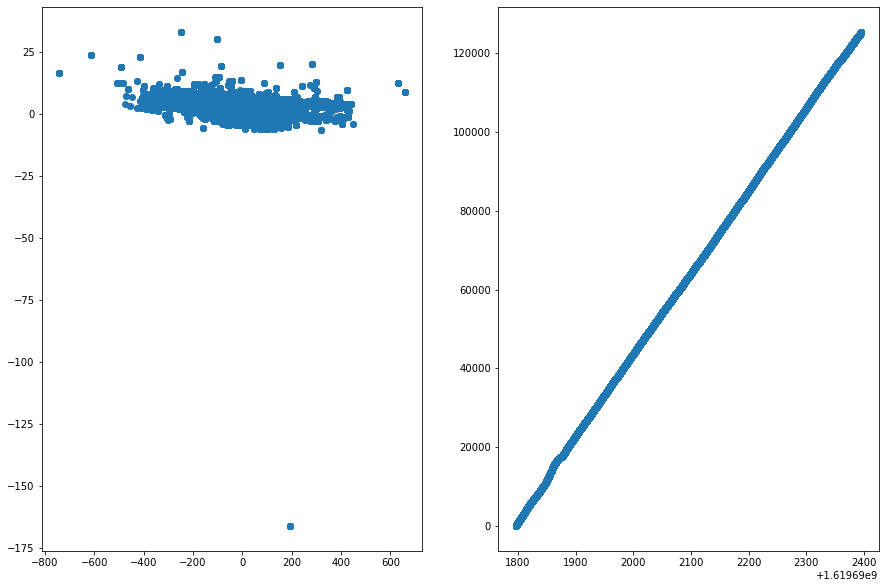

In [100]:
plt.figure(figsize = (15,10))
plt.subplot(1,2,1)
plt.scatter(hitpoints_df["hitObjectColliderBoundsCenter.x"], hitpoints_df["hitObjectColliderBoundsCenter.y"])
plt.subplot(1,2,2)
plt.scatter(hitpoints_df["timeStampDataPointStart"], range(0,len(hitpoints_df)))